In [1]:
#Importing necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import warnings
warnings.simplefilter('ignore')
import mplfinance as mpf
from pandas.plotting import lag_plot
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Downloading the stock data
start = '2015-01-01'
end = '2020-07-30'
ticker = 'JNJ'
interval = "1d"
df =yf.download(ticker,start,end,interval)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculating the stock return
df['Return'] =100*df['Adj Close'].pct_change()
df.drop(['Dividends','Stock Splits'],axis=1,inplace=True)
df.dropna(inplace=True)

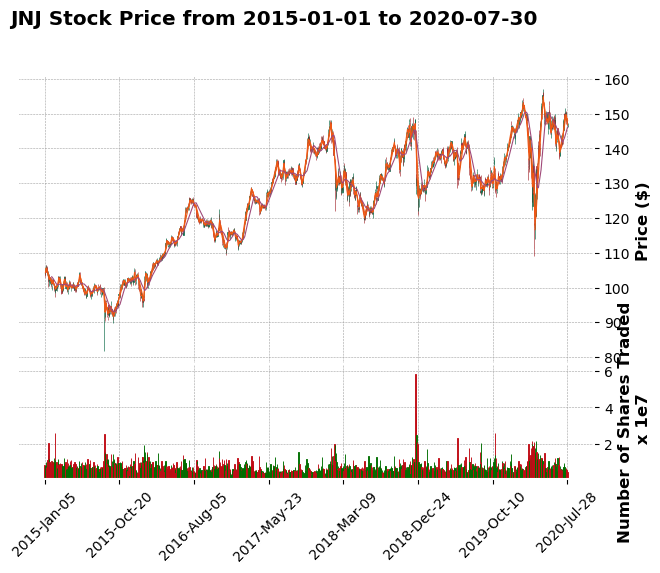

In [4]:
# Visualizing the stock price and volume

mpf.plot(df, type='candle', style='charles',
            title=ticker+' Stock Price from '+start+' to '+end ,
            ylabel='Price ($)',
            ylabel_lower='Number of Shares Traded',
            volume=True, 
            mav=(3,6,20), 
           )
plt.show()

In [5]:
# Information summary of the stock data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1402 entries, 2015-01-05 to 2020-07-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1402 non-null   float64
 1   High       1402 non-null   float64
 2   Low        1402 non-null   float64
 3   Close      1402 non-null   float64
 4   Adj Close  1402 non-null   float64
 5   Volume     1402 non-null   int64  
 6   Return     1402 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 87.6 KB


In [6]:
# Describtive statistical summary of stock data
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Return
count,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1.402000e+03,1402.000000
mean,124.466519,125.344643,123.552768,124.484194,114.740364,7.472987e+06,0.042402
std,15.892728,16.054849,15.741018,15.882112,18.896744,3.402751e+06,1.227700
min,90.699997,91.879997,81.790001,90.730003,78.699524,2.353800e+06,-10.037869
25%,112.797501,113.402502,112.272497,112.812502,100.079229,5.525175e+06,-0.444299
50%,127.994999,129.105003,126.925003,128.065002,119.406631,6.707000e+06,0.049306
75%,137.450005,138.547497,136.417500,137.312504,129.464581,8.503900e+06,0.597009
max,155.570007,157.000000,154.000000,155.509995,152.359604,5.814020e+07,7.997725


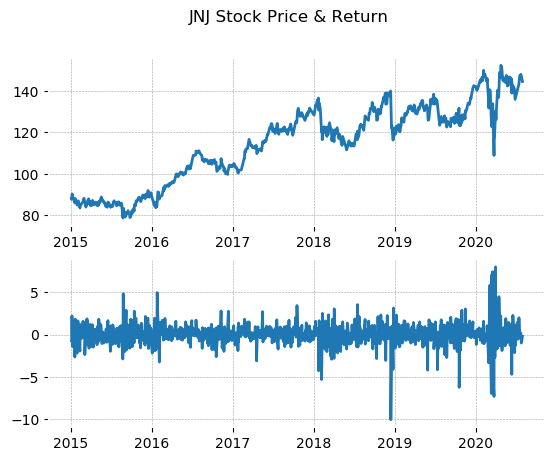

In [7]:
# Plotting Stock Price and Return
fig, axs = plt.subplots(2)
fig.suptitle(ticker+' Stock Price & Return')
axs[0].plot(df.index, df['Adj Close'])
axs[1].plot(df.index, df['Return'])
plt.show()

No handles with labels found to put in legend.


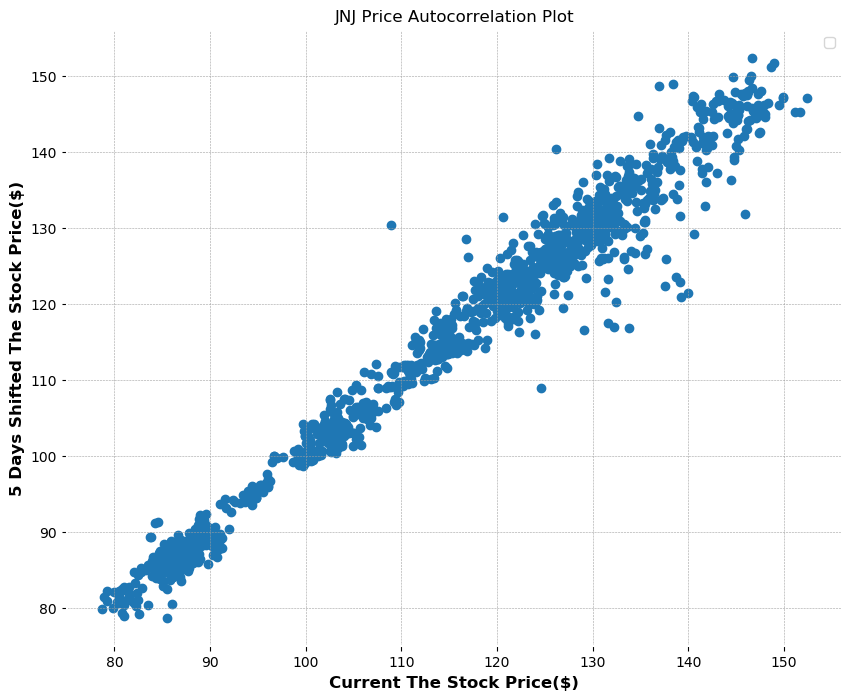

In [9]:
# The stock price's 5 days autocorrelation
plt.figure(figsize=(10,8))
lag_plot(df['Adj Close'], lag=5)
plt.title(ticker+' Price Autocorrelation Plot')
plt.xlabel('Current The Stock Price($)')
plt.ylabel('5 Days Shifted The Stock Price($)')
plt.grid(True)
plt.legend()
plt.show()

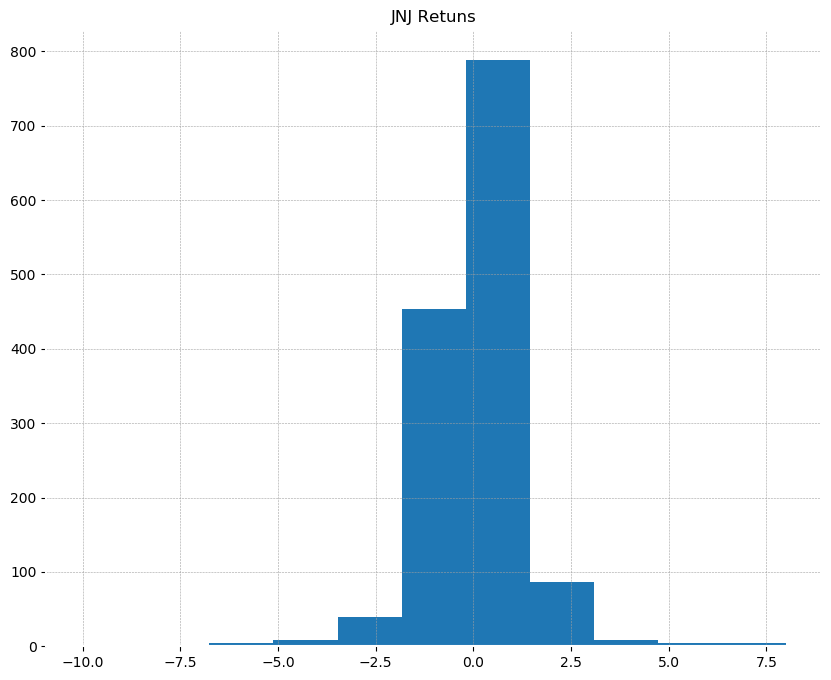

In [11]:
# Visualizing Distribution of Stock Returns
bins = int(round(1 + (3.322*np.log10(len(df)))))

fig= plt.figure(figsize=(10,8))
plt.hist(df['Return'].values,bins=bins)
plt.xlabel = 'Returns'
plt.ylabel = 'Frequency'
plt.title(ticker+' Retuns')
plt.show()

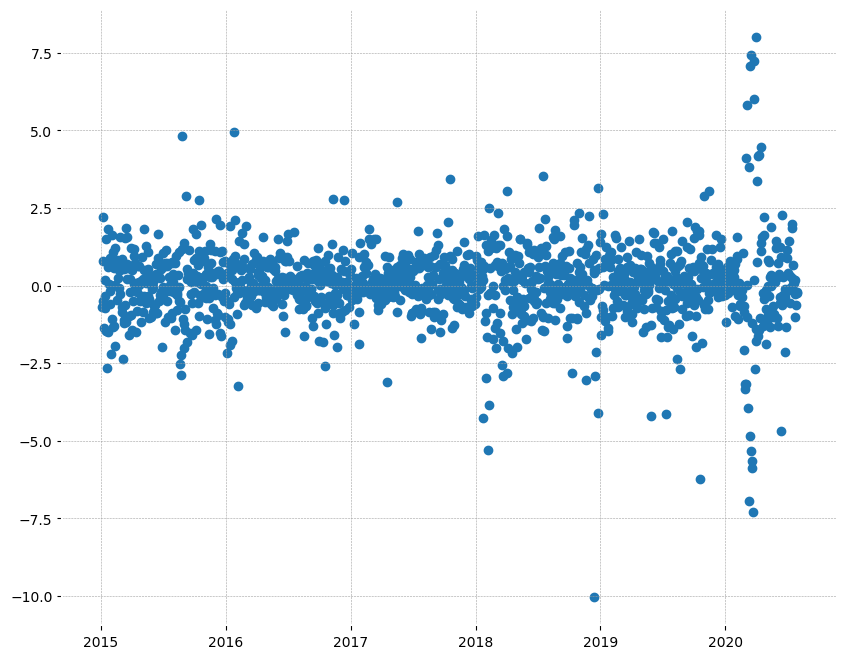

In [12]:
# The stock returns overtime
fig = plt.figure(figsize=(10,8))
plt.scatter(x=df.index,y=df['Return'].values)
plt.show()

In [14]:
# Specify and fit a GARCH model
split_date = '2020-02-07'
basic_gm = arch_model(df['Return'], vol='Garch', p=1, o=0, q=1, dist='skewt')
res = basic_gm.fit(disp='off',last_obs=split_date)

In [16]:
forcast_first_observation_date = '2020-02-08'
# Make variance forecast
forecasts = res.forecast(start = forcast_first_observation_date)
cond_mean = forecasts.mean[forcast_first_observation_date:]
cond_var = forecasts.variance[forcast_first_observation_date:]
q = basic_gm.distribution.ppf([0.01, 0.05], res.params[-2:])

In [17]:
print('1% parametric quantile: ',q[0], '5% parametric quantile: ', q[1])


1% parametric quantile:  -2.693539949737472 5% parametric quantile:  -1.5484173258690712


In [18]:
# Calculate the VaR
VaR_parametric = cond_mean.values + np.sqrt(cond_var).values * q[1]

# Save VaR in a DataFrame
VaR_parametric = pd.DataFrame(VaR_parametric, columns = ['5%'], index = cond_var.index)


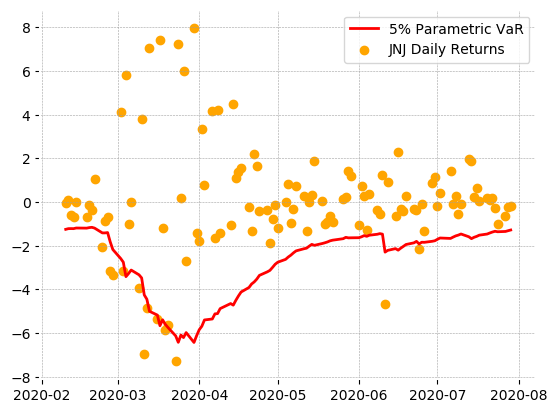

In [20]:
# Plot the VaR
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR')
plt.scatter(cond_var.index,df.Return[forcast_first_observation_date:], color = 'orange', label = ticker+' Daily Returns' )
plt.legend(loc = 'upper right')
plt.show()

In [21]:
# Empirical VaR Obtain the empirical quantile

gm_resid = res.resid.dropna()
gm_std = res.conditional_volatility.dropna()

std_resid = gm_resid /gm_std

q_empirical = std_resid.quantile(0.05)
print('5% empirical quantile: ', q_empirical)

5% empirical quantile:  -1.5092164818510763


In [22]:
# Calculate the VaR
VaR_empirical = cond_mean.values + np.sqrt(cond_var).values * q_empirical


In [23]:
# Save VaR in a DataFrame
VaR_empirical = pd.DataFrame(VaR_empirical, columns = ['5%'], index = cond_var.index)


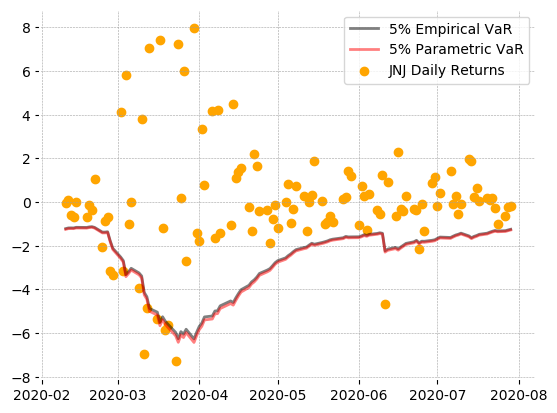

In [28]:
# Plot the VaRs
plt.plot(VaR_empirical, color = 'black', label = '5% Empirical VaR',alpha=0.5)
plt.plot(VaR_parametric, color = 'red', label = '5% Parametric VaR',alpha=0.5)
plt.scatter(cond_var.index,df.Return[forcast_first_observation_date:], color = 'orange', label = ticker+' Daily Returns' )
plt.legend(loc = 'upper right')
plt.show()
